In [ ]:
using BSON, Lux, Random, NNlib, JLD2
include("analysis_tools.jl")
include("models.jl");

In [ ]:
loaded = BSON.load("models/trained_model_trial.bson")
model = loaded[:model]
Xμ = loaded[:Xμ]
Xσ  = loaded[:Xσ];

In [ ]:
show_unrolling("data/burgers1d_periodicBase.jld2", model, Xμ, Xσ, "media/TEMP.gif")

In [ ]:
show_plots("data/burgers1d_periodicBase.jld2", model, Xμ, Xσ, "media/TEMP.png")

In [1]:
using Lux, Reactant, Enzyme, Zygote, Optimisers, MLUtils, Random, Statistics, JLD2, Plots, NNlib, ProgressMeter, BSON
include("analysis_tools.jl")
include("models.jl")

const cdev = cpu_device()
const xdev = reactant_device(; force=true)

function get_total_error(testing_model, trainpath, truthpath, testpath, nseeds)
    total_errors = []
    # Settings
    epochs = 1000
    batchsize = 40
    learning_rate = 0.005f0
    
    seed = 3
    ad_backend = AutoEnzyme()
    
    n_in = 1
    n_out = 1
    n_hidden = 8
    n_filter = 3;
    
    X_data=load(trainpath)
    y_data=load(truthpath)
    
    n_steps = length(X_data["solution"])-1
    n_points = length(X_data["solution"][1])
    
    X = zeros(Float32, n_points, 1, n_steps)
    y = zeros(Float32, n_points, 1, n_steps)
    for t in 1:n_steps
        X[:,:,t] .= X_data["solution"][t]
        y[:,:,t] .= y_data["solution"][t+1]
    end
    
    Xμ = mean(X)
    Xσ = std(X)
    X = (X .- Xμ) ./ Xσ
    y = (y .- Xμ) ./ Xσ
    
    dataloader = DataLoader((X, y), batchsize=batchsize, shuffle=true, partial=false) |> xdev
    
    function loss_function(model, ps, st, (X_batch, y_batch))
        smodel = StatefulLuxLayer(model, ps, st)
        y_pred = smodel(X_batch)
        
        data_loss = mean(abs2, y_pred .- y_batch)
        loss = data_loss
        return loss, st, (; data_loss, total_loss=loss)
    end
    
    model_function = testing_model(n_filter, n_in, n_hidden, n_out)
    
    @showprogress for seed in 1:nseeds
        rng = Random.default_rng()
        Random.seed!(rng, seed)
        
        ps, st = Lux.setup(rng, model_function) |> xdev
        
        train_state = Training.TrainState(model_function, ps, st, Adam(learning_rate))
        
        lr = i -> i < 500 ? 0.005f0 : (i < 1000 ? 0.0005f0 : 0.00005f0)
        
        for epoch in 1:epochs
            Optimisers.adjust!(train_state, lr(epoch))
            for batch in dataloader
                _, _, _, train_state = Training.single_train_step!(ad_backend,
                                                                      loss_function,
                                                                      batch,
                                                                      train_state;
                                                                      return_gradients=Val(false),
                )
            end
        end
        
        model = StatefulLuxLayer(model_function, cdev(train_state.parameters), cdev(train_state.states))
        
        data_test = load(testpath)
        n_times_test = length(data_test["solution"])
        n_steps_test = n_times_test-1
        n_points_test = length(data_test["solution"][1])
        
        X_test = zeros(Float32, n_points_test, 1, n_steps_test)
        for t in 1:n_steps_test
            X_test[:,:,t] .= data_test["solution"][t]
        end
        
        X_norm_test = (X_test .- Xμ) ./ Xσ
        
        x0 = X_norm_test[:,:,1]
        
        x = reshape(x0, size(x0, 1), size(x0, 2), 1)
        y_unroll = zeros(Float32, size(x0, 1), size(x0, 2), n_times_test)
        y_unroll[:,:,1] .= x0
        
        for t in 1:(n_times_test-1)
            x = model(x)
            y_unroll[:,:,t+1] .= x
        end
        
        y_unroll = (y_unroll .* Xσ) .+ Xμ
        
        errors = zeros(n_steps_test)
        for i in 1:n_steps_test
            errors[i] = mean(abs2, y_unroll[:,1,i] .- X_test[:,1,i])
        end
        push!(total_errors, mean(errors))
    end
    return total_errors
end;

In [2]:
nseeds=400
cutoff=0.1

trainpath="data/burgers1d_periodicBase.jld2"
truthpath="data/burgers1d_periodicBase.jld2"
testpath="data/burgers1d_periodicBase.jld2"

total_errors_base = get_total_error(BaseModel, trainpath, truthpath, testpath, nseeds)
total_errors_flux = get_total_error(FluxModel, trainpath, truthpath, testpath, nseeds)

trainpathNoised="data/burgers1d_periodicNoised.jld2"

total_errors_base_noised = get_total_error(BaseModel, trainpathNoised, truthpath, testpath, nseeds)
total_errors_flux_noised = get_total_error(FluxModel, trainpathNoised, truthpath, testpath, nseeds);

I0000 00:00:1758304904.486019   46677 service.cc:163] XLA service 0x1e10b710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758304904.486041   46677 service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
I0000 00:00:1758304904.486359   46677 se_gpu_pjrt_client.cc:1338] Using BFC allocator.
I0000 00:00:1758304904.486389   46677 gpu_helpers.cc:136] XLA backend allocating 6159925248 bytes on device 0 for BFCAllocator.
I0000 00:00:1758304904.486416   46677 gpu_helpers.cc:177] XLA backend will use up to 2053308416 bytes on device 0 for CollectiveBFCAllocator.
I0000 00:00:1758304904.495704   46677 cuda_dnn.cc:463] Loaded cuDNN version 90800
Progress: 100%|█████████████████████████████████████████| Time: 0:30:53
Progress: 100%|█████████████████████████████████████████| Time: 0:32:22
Progress: 100%|█████████████████████████████████████████| Time: 0:31:17
Progress: 100%|███████████████████████████████

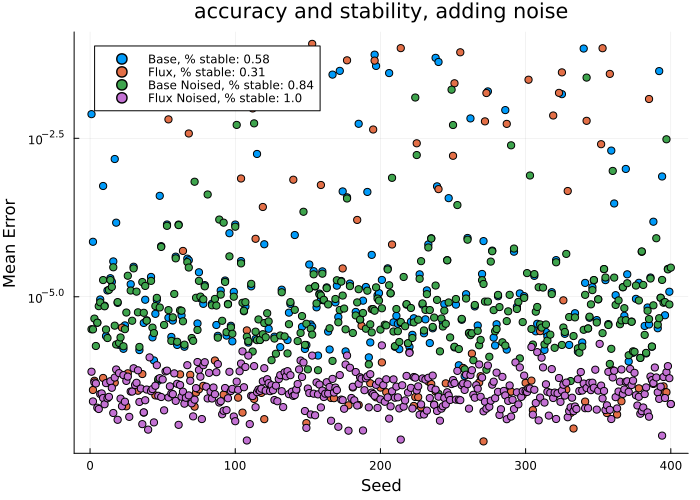

"/home/matspc/SSD/surrogate_flow/media/noising_comparison.png"

In [6]:
function filter_stable!(total_errors, cutoff)
    n_stable = 0
    for i in 1:length(total_errors)
        if (abs(total_errors[i]) < cutoff)
            n_stable += 1
        else
            total_errors[i] = NaN
        end
    end
    return n_stable
end
n_stable_base = filter_stable!(total_errors_base, cutoff)
n_stable_flux = filter_stable!(total_errors_flux, cutoff)
n_stable_base_noised = filter_stable!(total_errors_base_noised, cutoff)
n_stable_flux_noised = filter_stable!(total_errors_flux_noised, cutoff)

s = scatter(total_errors_base, xlabel="Seed", ylabel="Mean Error", label="Base, % stable: $(round(n_stable_base/nseeds,digits=2))", legend=:topleft, yscale=:log10, title="accuracy and stability, adding noise")
scatter!(s, total_errors_flux, label=label="Flux, % stable: $(round(n_stable_flux/nseeds,digits=2))")
scatter!(s, total_errors_base_noised, label=label="Base Noised, % stable: $(round(n_stable_base_noised/nseeds,digits=2))")
scatter!(s, total_errors_flux_noised, label=label="Flux Noised, % stable: $(round(n_stable_flux_noised/nseeds,digits=2))")
fig = scatter(s, size=(700,500))
display(fig)
savefig(fig, "media/noising_comparison.png")